In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# 7. Metropolis: Normal-Cauchy*

Adapted from [Unit 5: norcaumet.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/norcaumet.m).

For this example, our model is:

$$
\begin{align}
X \mid \theta &\sim N(\theta, 1) \\
\theta &\sim \text{Cauchy}(0, 1)
\end{align}
$$

We have a single datapoint, $x=2$. The professor chose a $N(x, 1)$ proposal. This is not symmetric around the current state of the chain, so it doesn't satisfy $q(\theta^\prime| \theta) = q(\theta | \theta^\prime)$ and we must use Metropolis-Hastings.

## Original method

Here's how we set up this problem. Assuming we have $n$ independent data points, the likelihood is:

$$
\begin{align*}
L(\theta; X) &= \prod_{i=1}^n \frac{1}{\sqrt{2\pi}} \exp\!\left(-\frac{(x_i-\theta)^2}{2}\right) \\
&\propto \prod_{i=1}^n \exp\!\left(-\frac{(x_i-\theta)^2}{2}\right)
\end{align*}
$$

The Cauchy prior density is:

$$
\pi(\theta) = \frac{1}{\pi (1+\theta^2)}
$$

Then our posterior is proportional to:

$$
\begin{align*}
\pi(\theta \mid X) &\propto L(\theta; x_{1:n}) \, \pi(\theta) \\
&\propto \left[\prod_{i=1}^n \exp\!\left(-\frac{(x_i-\theta)^2}{2}\right)\right] \frac{1}{1+\theta^2}
\end{align*}
$$

When proposing a new value $\theta'$ from a proposal density $ q(\theta' \mid \theta) $, the acceptance ratio is defined as:

$$
\rho = \frac{\pi(\theta' \mid X)\, q(\theta \mid \theta')}{\pi(\theta \mid X)\, q(\theta' \mid \theta)}
$$

Substituting the expression for the posterior, we get:

$$
\begin{align*}
\rho &= \frac{\left\{\prod_{i=1}^n \exp\!\left(-\frac{(x_i-\theta')^2}{2}\right)\right\} \frac{1}{1+(\theta')^2}\, q(\theta \mid \theta')}{\left\{\prod_{i=1}^n \exp\!\left(-\frac{(x_i-\theta)^2}{2}\right)\right\} \frac{1}{1+\theta^2}\, q(\theta' \mid \theta)} \\
&= \frac{1+\theta^2}{1+(\theta')^2} \, \exp\!\left\{-\frac{1}{2}\sum_{i=1}^n \Bigl[ (x_i-\theta')^2 - (x_i-\theta)^2 \Bigr]\right\}\, \frac{q(\theta \mid \theta')}{q(\theta' \mid \theta)}\\
&= \frac{1+\theta^2}{1+(\theta')^2} \, \exp\!\left\{-\frac{1}{2} \Bigl[ (2-\theta')^2 - (2-\theta)^2 \Bigr]\right\}\, \frac{q(\theta \mid \theta')}{q(\theta' \mid \theta)}
\end{align*}
$$

Now there are a lot of ways to choose the proposal $q(\cdot)$. In this case, the professor has chosen one that will simplify our acceptance ratio expression quite a bit, $N(x, 1)$. I'll also show how a random walk proposal would work later.

For this example, remember $n=1$ and $x=2$.

Since the professor chooses an "independence" proposal, the proposal density is independent of the current state:

$$
q(\theta' \mid \theta) = q(\theta') = N(2, 1)
$$

$$
q(\theta \mid \theta') = q(\theta) = N(2, 1)
$$

The ratio of the proposal densities becomes

$$
\begin{align*}
\frac{q(\theta \mid \theta')}{q(\theta' \mid \theta)} &= \frac{N(2,1)(\theta)}{N(2,1)(\theta')} \\
&= \frac{\frac{1}{\sqrt{2\pi}} \exp\!\left(-\frac{1}{2}(\theta-2)^2\right)}
{\frac{1}{\sqrt{2\pi}} \exp\!\left(-\frac{1}{2}(\theta'-2)^2\right)}\\
&= \exp\!\left\{-\frac{1}{2}\Bigl[(\theta-2)^2 - (\theta'-2)^2\Bigr]\right\}\\
\end{align*}
$$

Substitute this back into the acceptance ratio:

$$
\begin{align}
\rho &= \frac{1+\theta^2}{1+(\theta')^2}\, \exp\!\left\{-\frac{1}{2}\Bigl[(2-\theta')^2-(2-\theta)^2\Bigr]\\  -\frac{1}{2}\Bigl[(\theta-2)^2-(\theta'-2)^2\Bigr]\right\}
\end{align}
$$

Using the following fact:
$$
(2-\theta)^2 = (\theta-2)^2 \quad \text{and} \quad (2-\theta')^2 = (\theta'-2)^2
$$

So the exponential terms cancel:

$$
-\frac{1}{2}\Bigl[(2-\theta')^2-(2-\theta)^2\Bigr] -\frac{1}{2}\Bigl[(\theta-2)^2-(\theta'-2)^2\Bigr] = 0
$$

This leaves us with a simplified acceptance ratio:

$$
\rho = \frac{1+\theta^2}{1+\theta'^2}
$$

That's all we need to code our sampler.

```{warning}
I usually pre-generate arrays of random numbers (see ```theta_prop``` and ```unif``` variables in the below cell) because it's computationally faster. However, that only works when those numbers don't depend on the previous step in the sampling loop.
```

  0%|          | 0/1000000 [00:00<?, ?it/s]

np.mean(thetas)=1.283
np.var(thetas)=0.863
accepted/n=0.588


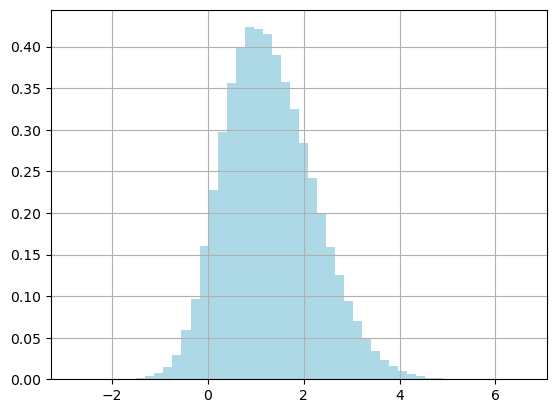

In [2]:
rng = np.random.default_rng(1)

n = 1000000  # observations
burn = 500
theta = 1  # init
thetas = np.zeros(n)
x = 2  # observed

accepted = 0

# generating necessary randoms as arrays is faster
theta_prop = rng.standard_normal(n) + x
unif = rng.uniform(size=n)

for i in tqdm(range(n)):
    r = (1 + theta**2) / (1 + theta_prop[i] ** 2)
    rho = min(r, 1)
    if unif[i] < rho:
        theta = theta_prop[i]
        accepted += 1
    thetas[i] = theta

thetas = thetas[burn:]

print(f"{np.mean(thetas)=:.3f}")
print(f"{np.var(thetas)=:.3f}")
print(f"{accepted/n=:.3f}")

fig, ax = plt.subplots()
ax.grid(True)
plt.hist(thetas, color="lightblue", density=True, bins=50)
plt.show()

## Random-walk proposal

How would we do this with classic Metropolis? We would use a random-walk proposal, centering the proposal at the previous state of the chain at each step.

Notice I can still pregenerate proposal values, because it's easy to adjust the pregenerated $N(0, 1)$ values by adding theta, which centers the distribution at the previous state of the chain.

  0%|          | 0/1000000 [00:00<?, ?it/s]

np.mean(thetas)=1.283
np.var(thetas)=0.865
accepted/n=0.686


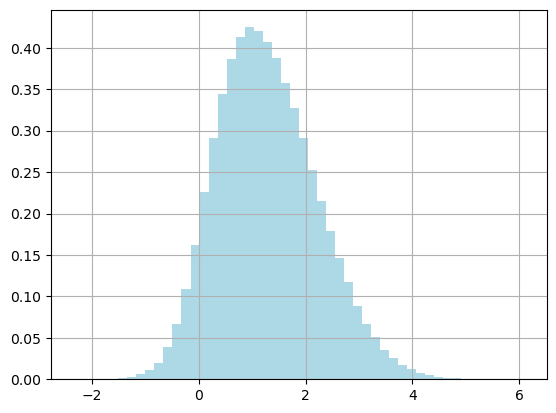

In [3]:
n = 1000000
burn = 500
theta = 1
thetas = np.zeros(n)
x = 2

accepted = 0

theta_prop = rng.standard_normal(n)
unif = rng.uniform(size=n)


def f(x, theta):
    return np.exp(-0.5 * (x - theta) ** 2) / (1 + theta**2)


for i in tqdm(range(n)):
    theta_prop_current = theta_prop[i] + theta

    r = f(x, theta_prop_current) / f(x, theta)
    rho = min(r, 1)

    if unif[i] < rho:
        theta = theta_prop_current
        accepted += 1

    thetas[i] = theta

thetas = thetas[burn:]

print(f"{np.mean(thetas)=:.3f}")
print(f"{np.var(thetas)=:.3f}")
print(f"{accepted/n=:.3f}")

fig, ax = plt.subplots()
ax.grid(True)
plt.hist(thetas, color="lightblue", density=True, bins=50)
plt.show()

The end results are the same, with a higher acceptance rate! Something to consider: do we always want this behavior from the sampler?

In [4]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Feb 13 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

matplotlib: 3.9.2
tqdm      : 4.67.0
numpy     : 1.26.4

